<center><h1>Gunadi_Eben_HW2</h1></center>
<br>
<br>

Name: Eben Gunadi
<br>
Github Username: egunadi
<br>
USC ID: 3976793880

## 1. Combined Cycle Power Plant Data Set

### (a) Download Data

Package imports

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

In [51]:
from matplotlib import style

print(plt.style.available)

['Solarize_Light2', '_classic_test_patch', '_mpl-gallery', '_mpl-gallery-nogrid', 'bmh', 'classic', 'dark_background', 'fast', 'fivethirtyeight', 'ggplot', 'grayscale', 'seaborn-v0_8', 'seaborn-v0_8-bright', 'seaborn-v0_8-colorblind', 'seaborn-v0_8-dark', 'seaborn-v0_8-dark-palette', 'seaborn-v0_8-darkgrid', 'seaborn-v0_8-deep', 'seaborn-v0_8-muted', 'seaborn-v0_8-notebook', 'seaborn-v0_8-paper', 'seaborn-v0_8-pastel', 'seaborn-v0_8-poster', 'seaborn-v0_8-talk', 'seaborn-v0_8-ticks', 'seaborn-v0_8-white', 'seaborn-v0_8-whitegrid', 'tableau-colorblind10']


In [86]:
# Set Matplotlib defaults
plt.style.use("seaborn-v0_8-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
%config InlineBackend.figure_format = 'retina'

Get the Cycle Power Plant Data Set

In [10]:
ccpp_file = pd.ExcelFile('../data/CCPP/Folds5x2_pp.xlsx', engine='openpyxl')
ccpp_df = pd.read_excel(ccpp_file, sheet_name=0)

In [12]:
ccpp_df.head()

AT      V       AP     RH      PE
0  14.96  41.76  1024.07  73.17  463.26
1  25.18  62.96  1020.04  59.08  444.37
2   5.11  39.40  1012.16  92.14  488.56
3  20.86  57.32  1010.24  76.64  446.48
4  10.82  37.50  1009.23  96.62  473.90

Per Readme.txt, independent variables are

- AT: Ambient Temperature
- V: Exhaust Vacuum
- AP: Ambient Pressure
- RH: Relative Humidity

and the dependent variable is

- PE: Energy Output

### (b) Exploring the data

#### i. rows and columns

In [21]:
# How many rows are in this data set? # How many columns? What do the rows and columns represent?
print(ccpp_df.shape[0], 'rows, or the number of samples in the data set')
print(ccpp_df.shape[1], 'columns, or the number of features in the data set')

9568 rows, or the number of samples in the data set
5 columns, or the number of features in the data set


#### ii. pairwise scatterplots of all the varianbles

/Users/ebengunadi/anaconda3/envs/dsci552-hw2/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/ebengunadi/anaconda3/envs/dsci552-hw2/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/ebengunadi/anaconda3/envs/dsci552-hw2/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/ebengunadi/anaconda3/envs/dsci552-hw2/lib/python3.9/site-packages/seaborn/_oldcore.py:1119: FutureWarning

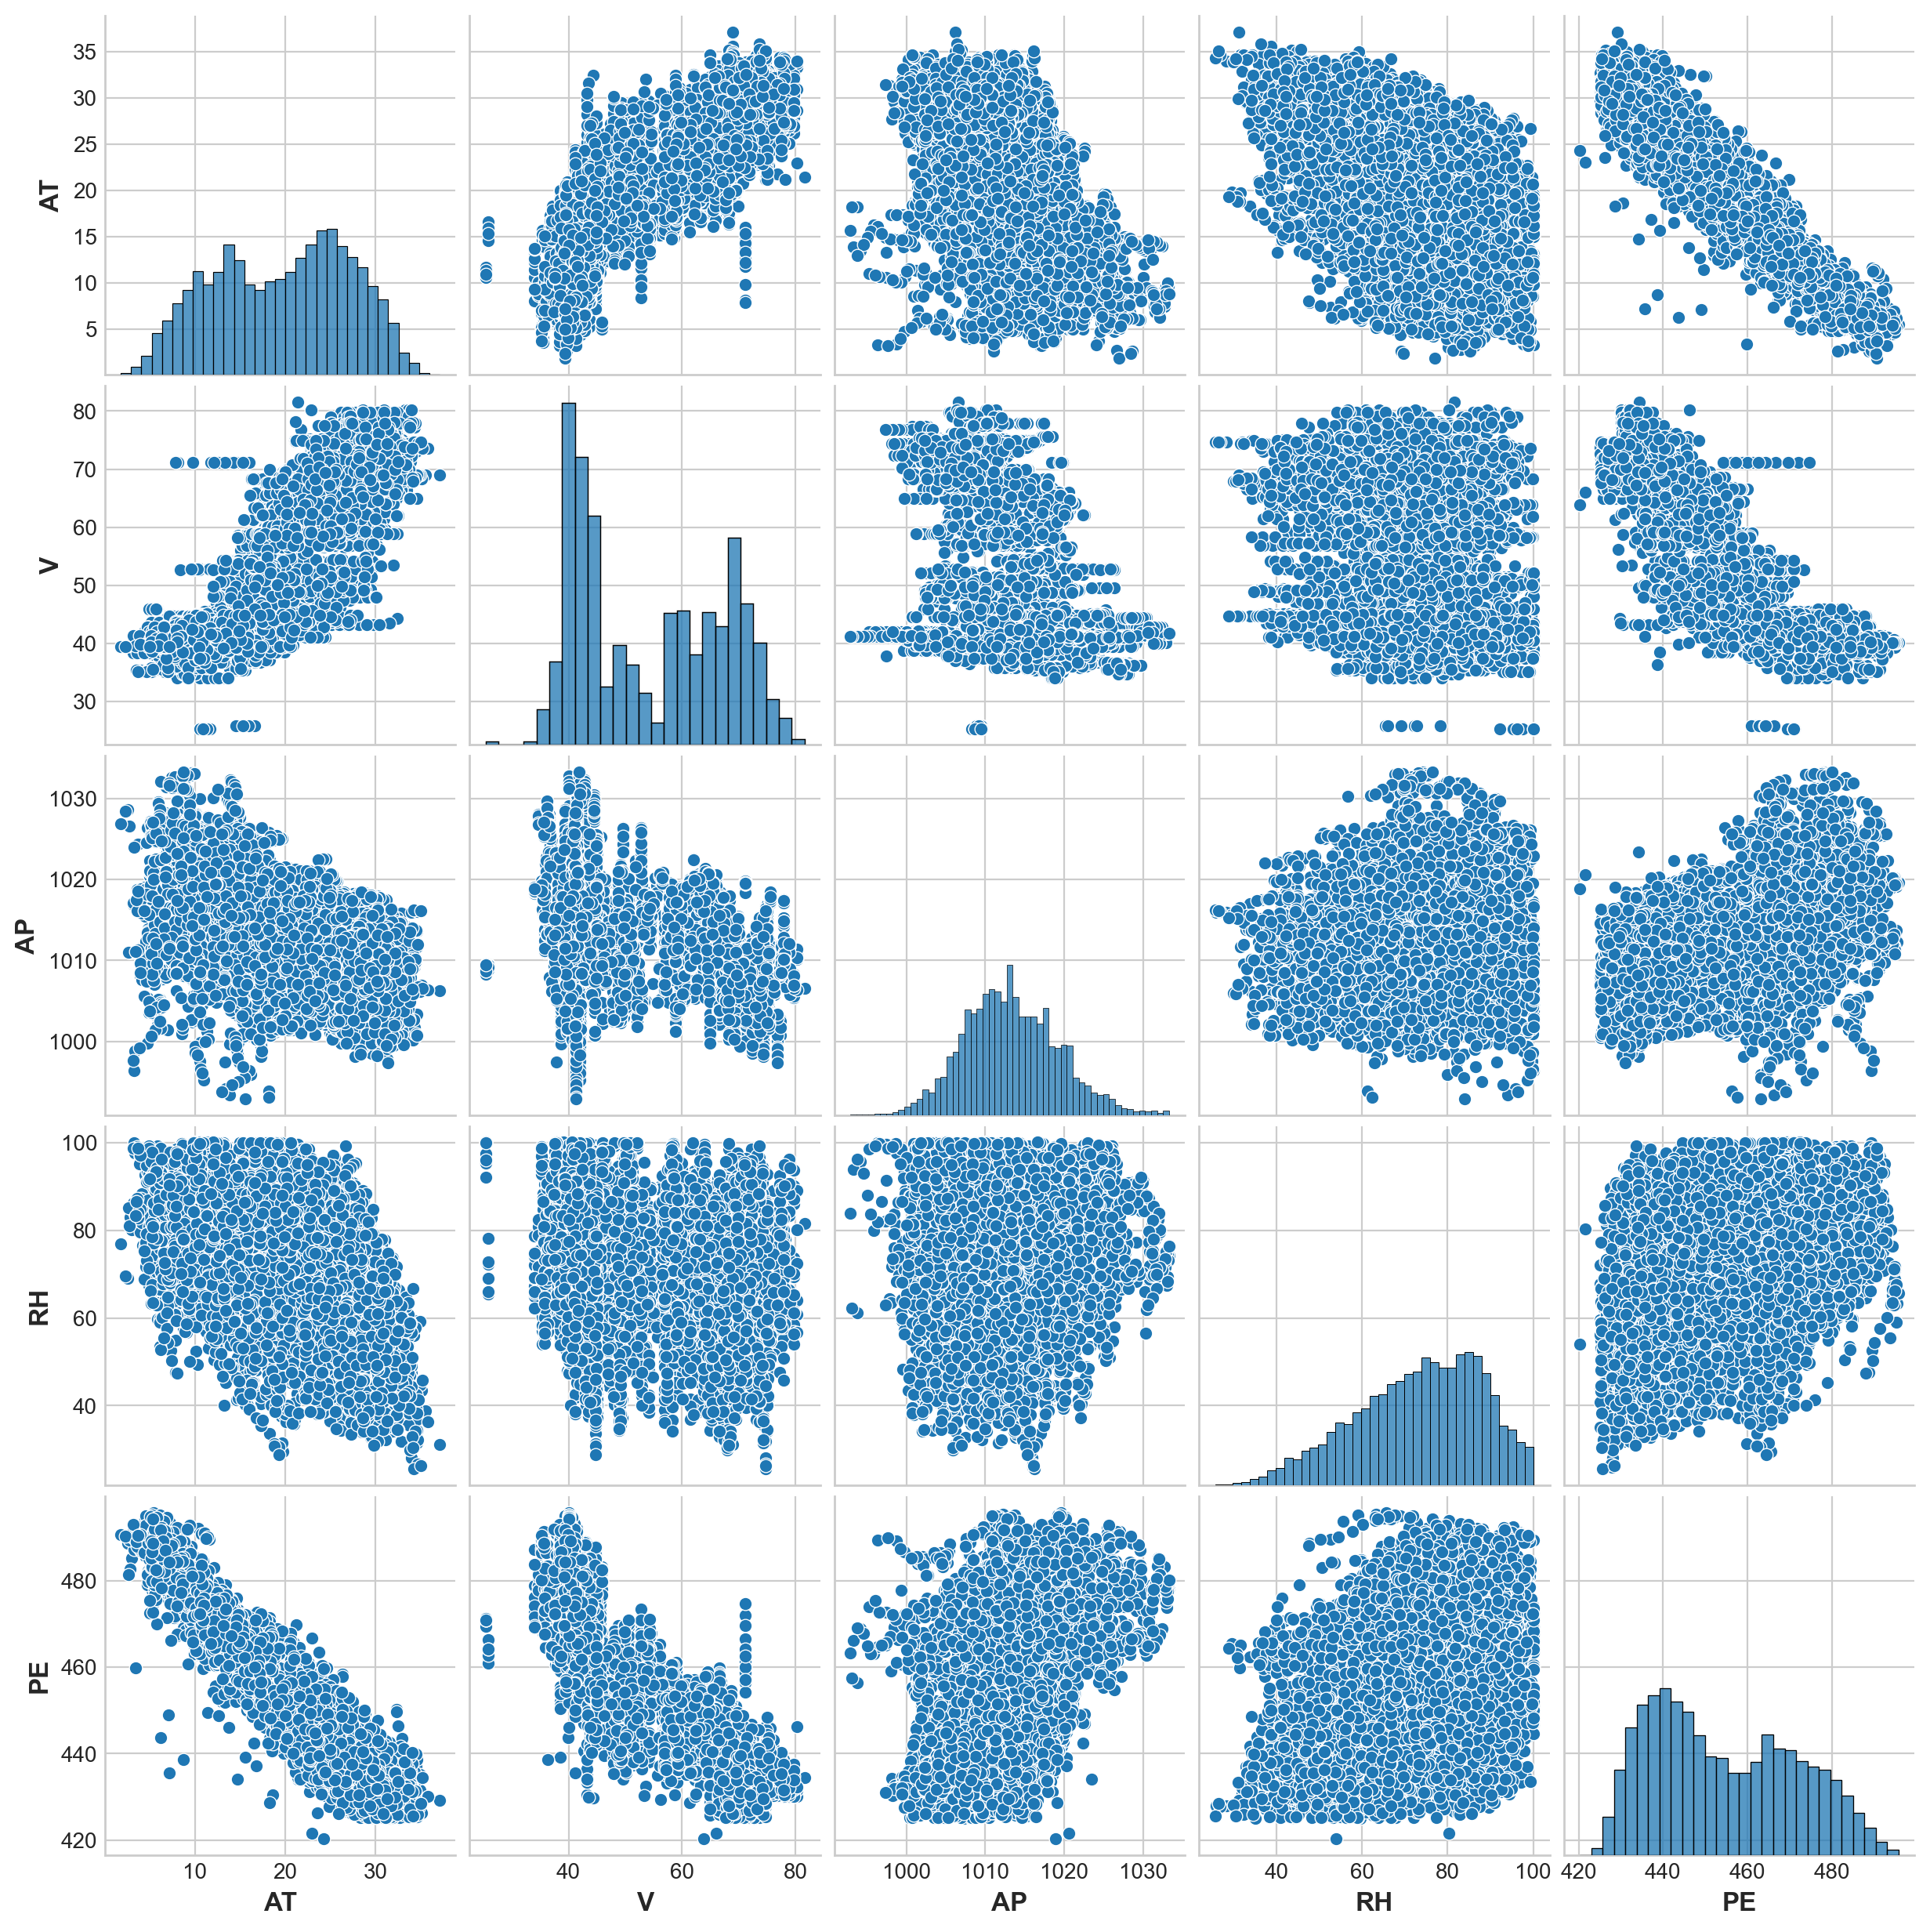

In [132]:
# Make pairwise scatterplots of all the varianbles in the data set including the predictors (independent variables) with the dependent variable. Describe your findings.
sns.pairplot(ccpp_df)

The following variables seem to be negatively correlated

- Energy Output (PE) and Ambient Temperature (AT)
- Energy Output (PE) and Exhaust Vacuum (V)

while the following positively correlated

- Ambient Temperature (AT) and Vacuum (V)

#### iii. mean, the median, range, first and third quartiles, and interquartile ranges

In [43]:
# What are the mean, the median, range, first and third quartiles, and in-terquartile ranges of each of the variables in the dataset? Summarize them in a table.
summary_df = ccpp_df.describe().T
summary_df['range'] = summary_df['max'] - summary_df['min']
summary_df['IQR'] = summary_df['75%'] - summary_df['25%']
summary_df = summary_df.rename(columns={'50%': 'median',
                                        '25%': 'first quartile',
                                        '75%': 'third quartile'})
summary_df[['mean', 'median', 'range', 'first quartile', 'third quartile', 'IQR']]

mean    median  range  first quartile  third quartile      IQR
AT    19.651231    20.345  35.30         13.5100           25.72  12.2100
V     54.305804    52.080  56.20         41.7400           66.54  24.8000
AP  1013.259078  1012.940  40.41       1009.1000         1017.26   8.1600
RH    73.308978    74.975  74.60         63.3275           84.83  21.5025
PE   454.365009   451.550  75.50        439.7500          468.43  28.6800

### (c) Simple Linear Regression

In [160]:
# For each predictor, fit a simple linear regression model to predict the response. Describe your results. In which of the models is there a statistically significant association between the predictor and the response? Create some plots to back up your assertions. Are there any outliers that you would like to remove from your data for each of these regression tasks?

X = ccpp_df[['AT', 'V', 'AP', 'RH']] # features
y = ccpp_df[['PE']] # target

predictions_df = pd.DataFrame()
lin_reg_summary_df = pd.DataFrame(columns=['coefficient', 'intercept', 'r-squared', 'p-value'])
for col in X.columns:
    # Train the model
    lin_reg_model = sm.OLS(y, sm.add_constant(X[[col]])).fit()

    # Store the fitted values with the same index as the training data
    predictions_df[col] = lin_reg_model.fittedvalues

    # Store the summary results for coefficient, intercept, r-squared, and p-value
    lin_reg_summary_df.loc[col] = [lin_reg_model.params[1], lin_reg_model.params[0], lin_reg_model.rsquared, lin_reg_model.pvalues[1]]

/var/folders/h1/r_7yspw94w77hrsrcwzwy75m0000gn/T/ipykernel_22024/311058885.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lin_reg_summary_df.loc[col] = [lin_reg_model.params[1], lin_reg_model.params[0], lin_reg_model.rsquared, lin_reg_model.pvalues[1]]
/var/folders/h1/r_7yspw94w77hrsrcwzwy75m0000gn/T/ipykernel_22024/311058885.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lin_reg_summary_df.loc[col] = [lin_reg_model.params[1], lin_reg_model.params[0], lin_reg_model.rsquared, lin_reg_model.pvalues[1]]
/var/folders/h1/r_7yspw94w77hrsrcwzwy75m0000gn/T/ipykernel_22024/311058885.py:16: FutureWarning: Series.__

In [161]:
lin_reg_summary_df

coefficient    intercept  r-squared  p-value
AT    -2.171320   497.034120   0.898948      0.0
V     -1.168135   517.801526   0.756518      0.0
AP     1.489872 -1055.260989   0.268769      0.0
RH     0.455650   420.961766   0.151939      0.0

All four predictors have p-values less than 5%, making them all statistically significant. High R-squared scores for AT and V explain why their correlation with PE was so noticeable, while their negative coefficients confirm that they are negatively correlated with V.

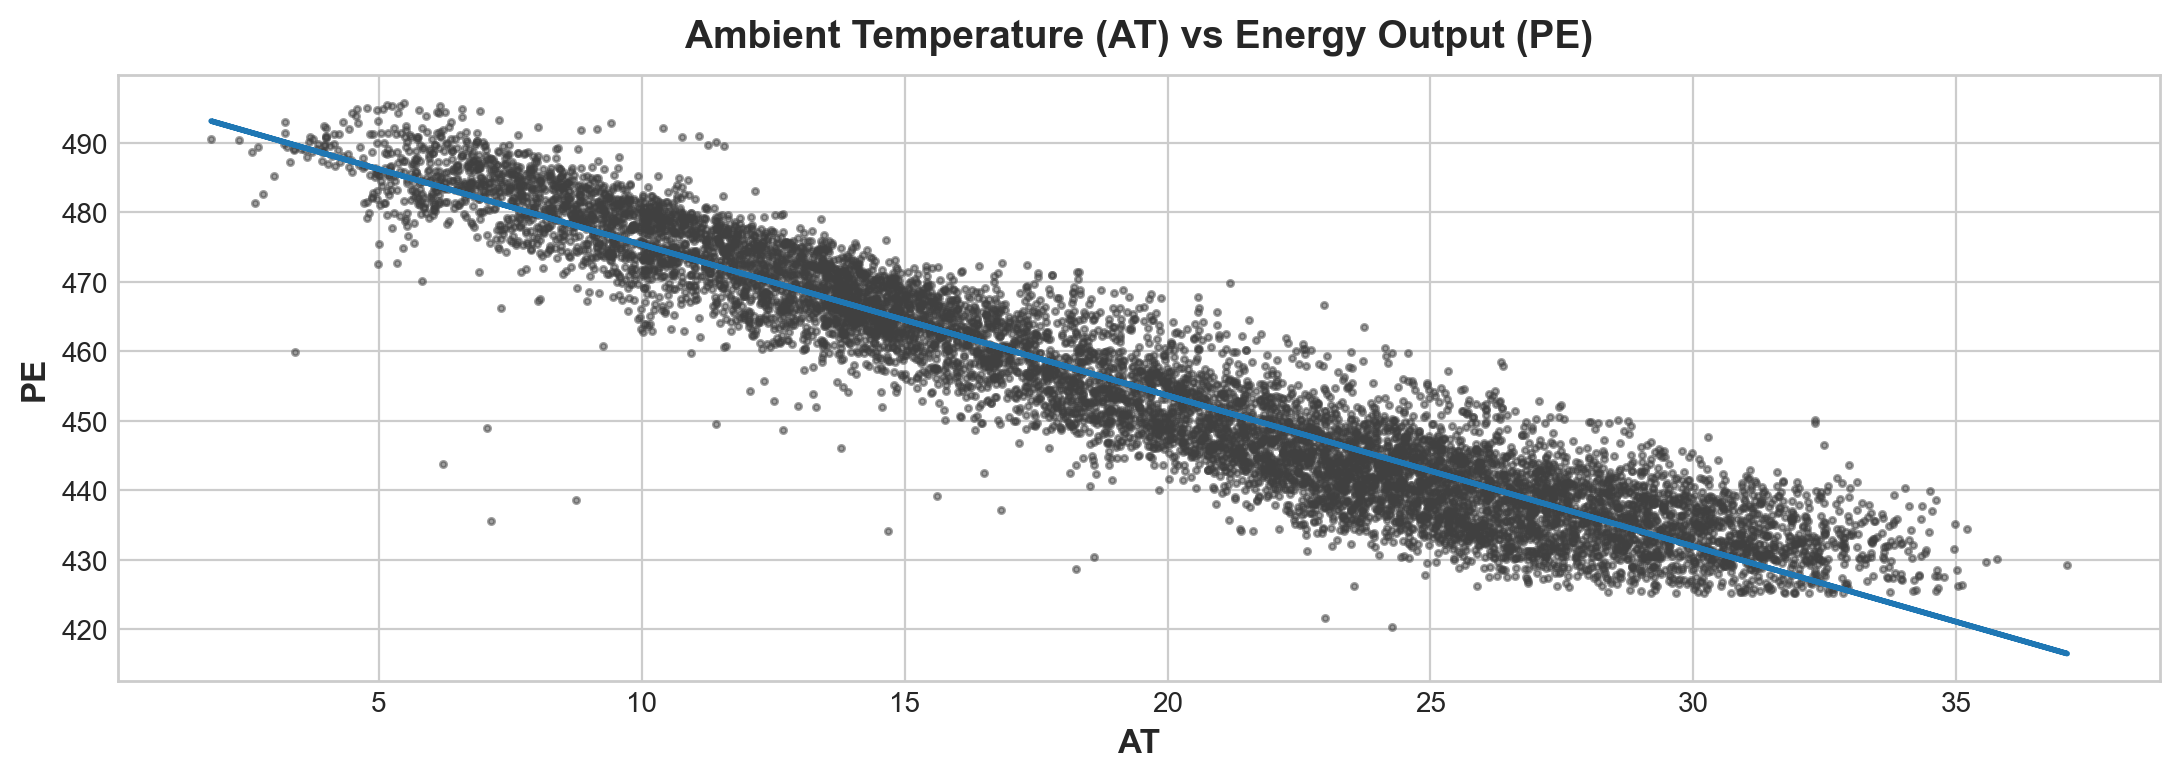

In [162]:
fig, ax = plt.subplots()
ax.scatter(ccpp_df['AT'], ccpp_df['PE'], color='0.25', alpha=0.5, s=5)
ax.plot(ccpp_df['AT'], predictions_df['AT'], linewidth=2)
ax.set_xlabel('AT')
ax.set_ylabel('PE')
ax.set_title('Ambient Temperature (AT) vs Energy Output (PE)');

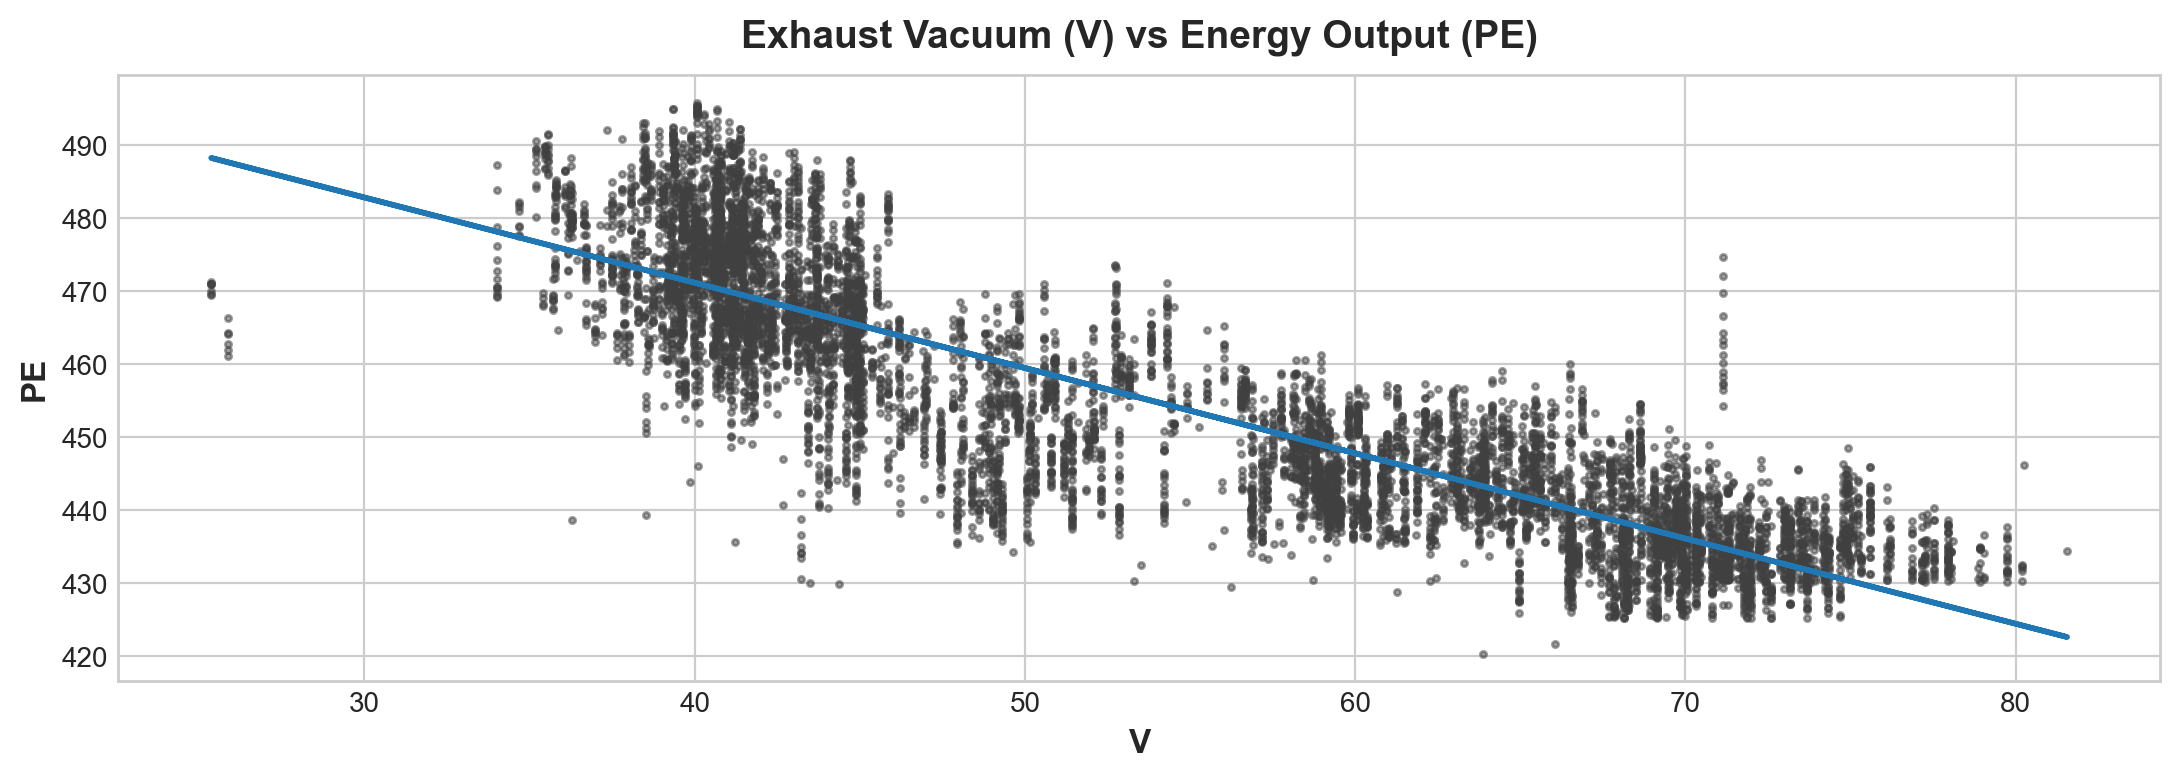

In [163]:
fig, ax = plt.subplots()
ax.scatter(ccpp_df['V'], ccpp_df['PE'], color='0.25', alpha=0.5, s=5)
ax.plot(ccpp_df['V'], predictions_df['V'], linewidth=2)
ax.set_xlabel('V')
ax.set_ylabel('PE')
ax.set_title('Exhaust Vacuum (V) vs Energy Output (PE)');

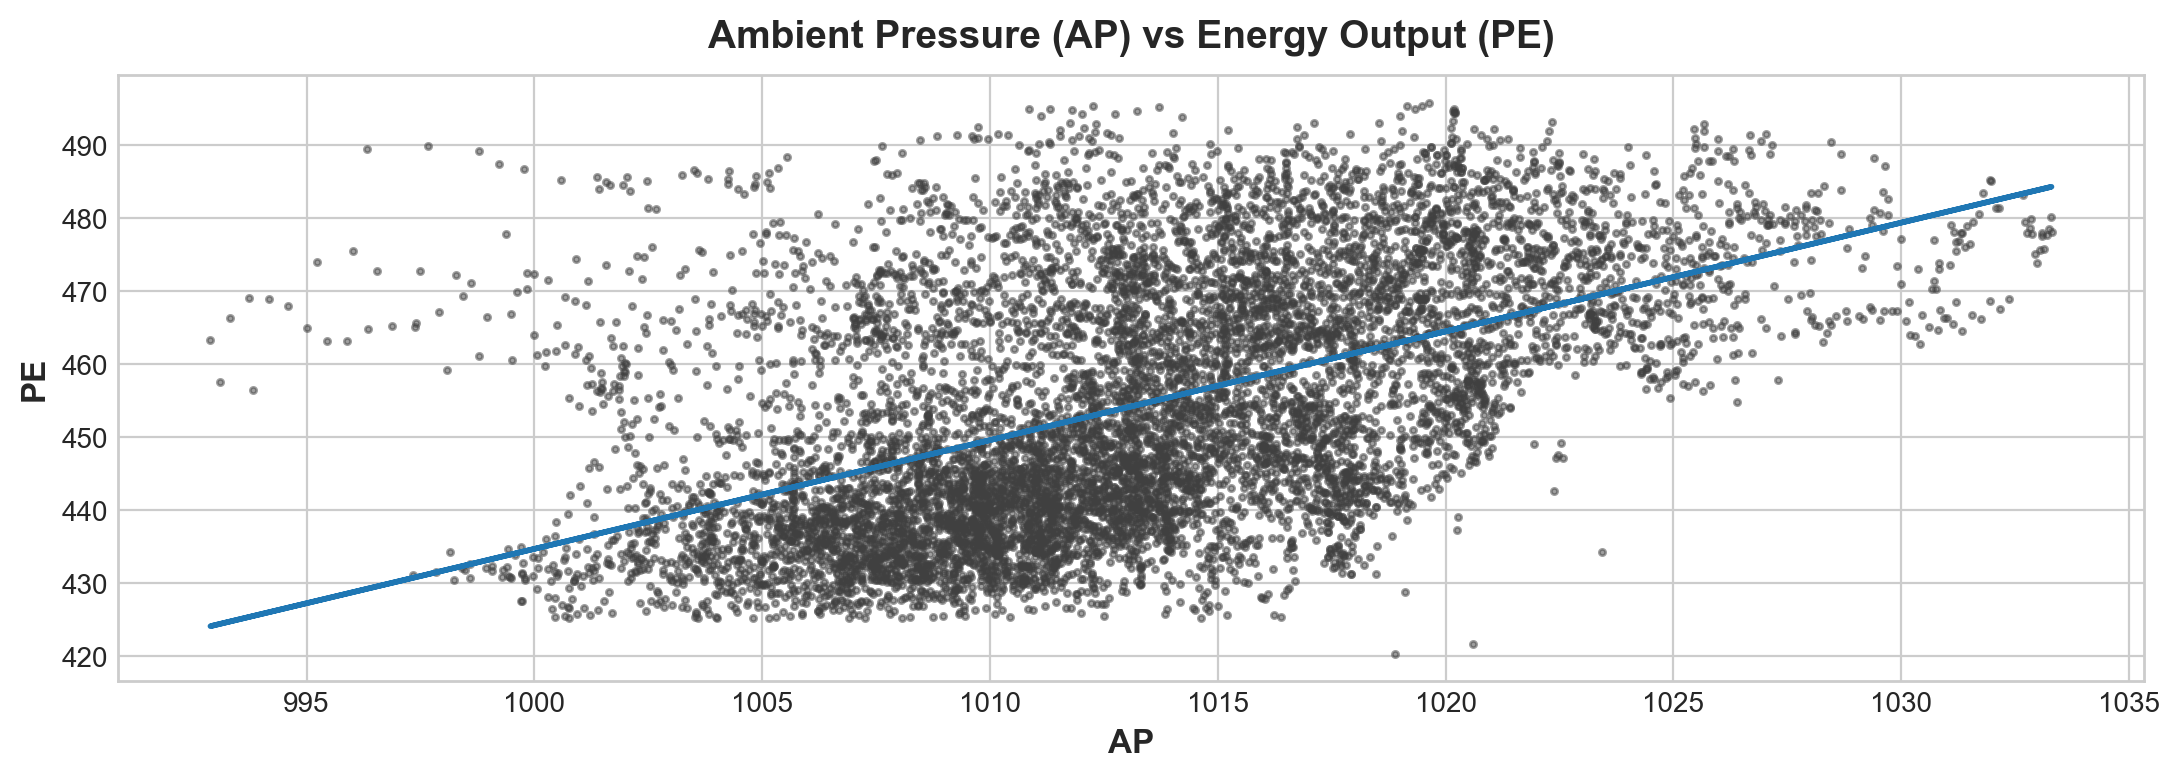

In [164]:
fig, ax = plt.subplots()
ax.scatter(ccpp_df['AP'], ccpp_df['PE'], color='0.25', alpha=0.5, s=5)
ax.plot(ccpp_df['AP'], predictions_df['AP'], linewidth=2)
ax.set_xlabel('AP')
ax.set_ylabel('PE')
ax.set_title('Ambient Pressure (AP) vs Energy Output (PE)');

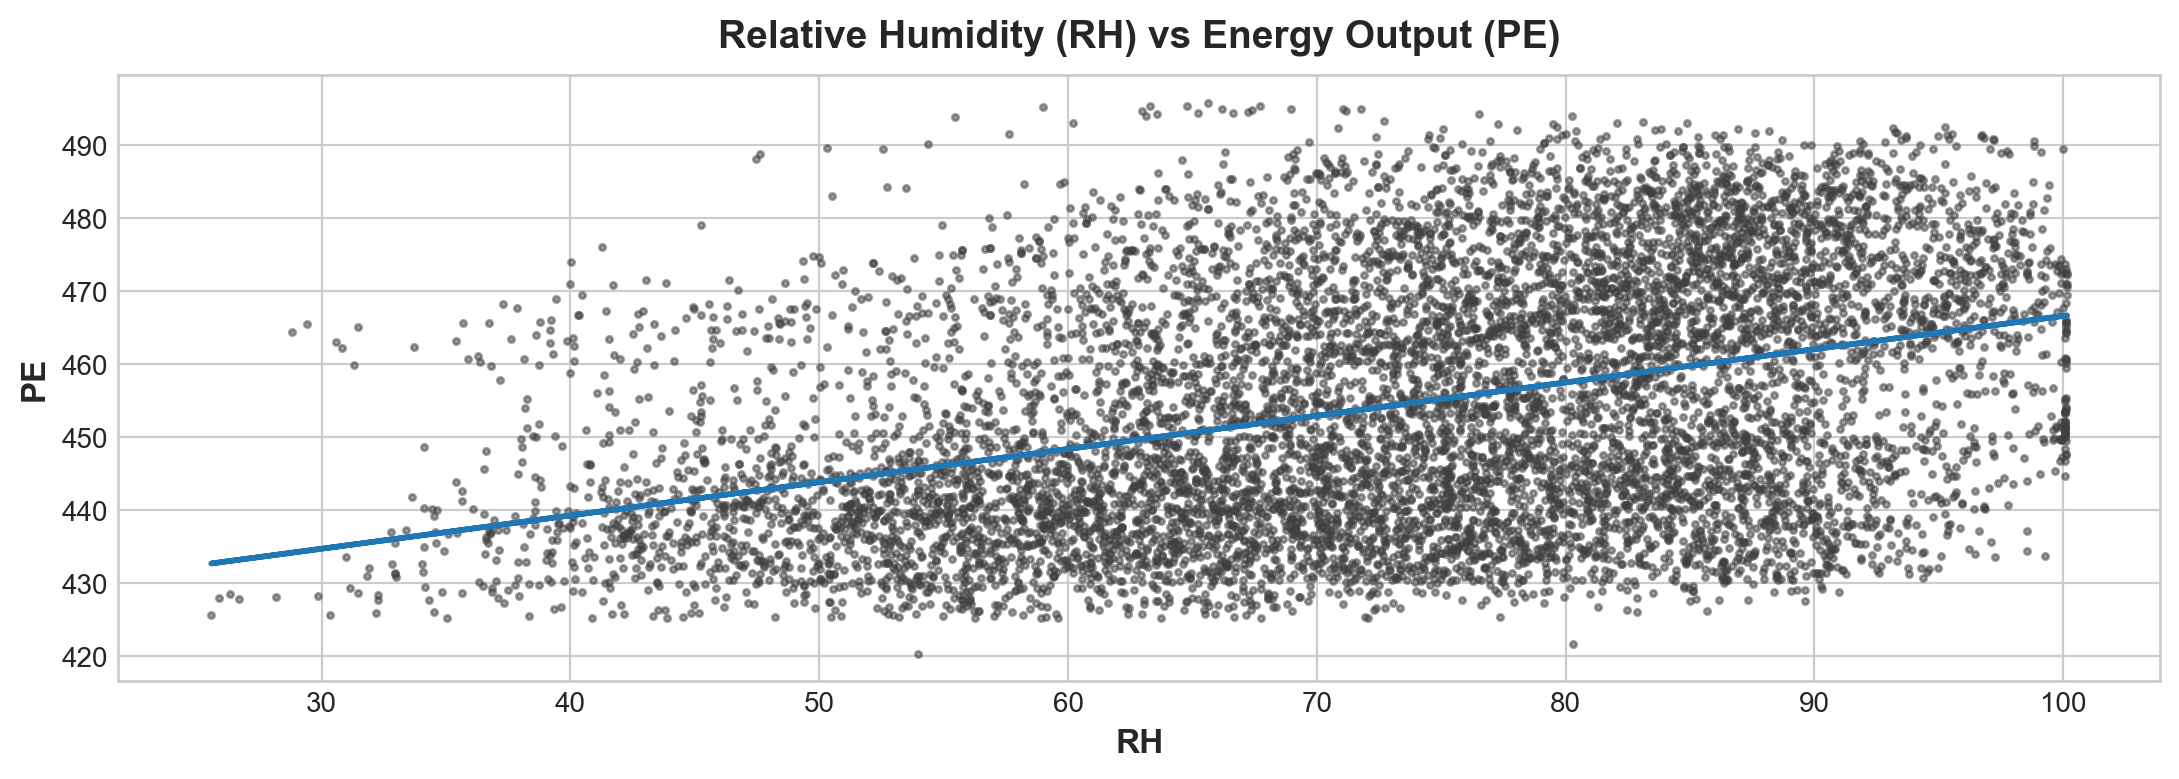

In [165]:
fig, ax = plt.subplots()
ax.scatter(ccpp_df['RH'], ccpp_df['PE'], color='0.25', alpha=0.5, s=5)
ax.plot(ccpp_df['RH'], predictions_df['RH'], linewidth=2)
ax.set_xlabel('RH')
ax.set_ylabel('PE')
ax.set_title('Relative Humidity (RH) vs Energy Output (PE)');

While there are noticeable outliers for each plot, per Dr. Rajati's advice we shouldn't be too quick to remove them. However, if my model lacks accuracy, I may remove data points that are 1.5 times the interquartile range away from Q1 or Q3.

### (d) Multiple Regression

In [168]:
# Fit a multiple regression model to predict the response using all of the predictors. Describe your results. For which predictors can we reject the null hypothesis H0 : βj = 0?

# Train the model
mult_reg_model = sm.OLS(y, sm.add_constant(X)).fit()

# Store the summary results for coefficient, intercept, r-squared, and p-value
mult_reg_summary_df = pd.DataFrame(columns=['coefficient', 'intercept', 'r-squared', 'p-value'])
mult_reg_summary_df.loc['AT'] = [mult_reg_model.params['AT'], mult_reg_model.params[0], mult_reg_model.rsquared, mult_reg_model.pvalues['AT']]
mult_reg_summary_df.loc['V'] = [mult_reg_model.params['V'], mult_reg_model.params[0], mult_reg_model.rsquared, mult_reg_model.pvalues['V']]
mult_reg_summary_df.loc['AP'] = [mult_reg_model.params['AP'], mult_reg_model.params[0], mult_reg_model.rsquared, mult_reg_model.pvalues['AP']]
mult_reg_summary_df.loc['RH'] = [mult_reg_model.params['RH'], mult_reg_model.params[0], mult_reg_model.rsquared, mult_reg_model.pvalues['RH']]
mult_reg_summary_df


/var/folders/h1/r_7yspw94w77hrsrcwzwy75m0000gn/T/ipykernel_22024/1929681097.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mult_reg_summary_df.loc['AT'] = [mult_reg_model.params['AT'], mult_reg_model.params[0], mult_reg_model.rsquared, mult_reg_model.pvalues['AT']]
/var/folders/h1/r_7yspw94w77hrsrcwzwy75m0000gn/T/ipykernel_22024/1929681097.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  mult_reg_summary_df.loc['V'] = [mult_reg_model.params['V'], mult_reg_model.params[0], mult_reg_model.rsquared, mult_reg_model.pvalues['V']]
/var/folders/h1/r_7yspw94w77hrsrcwzwy75m0000gn/T/ipykernel_22024/1929681097.py:10: Fu

coefficient   intercept  r-squared        p-value
AT    -1.977513  454.609274   0.928696   0.000000e+00
V     -0.233916  454.609274   0.928696  4.375305e-215
AP     0.062083  454.609274   0.928696   5.507109e-11
RH    -0.158054  454.609274   0.928696  3.104584e-293

As with simple linear regression, all four predictors have p-values less than 5% and are statistically significant.

### (e) 1c Compare to 1d

In [169]:
# How do your results from 1c compare to your results from 1d? 

combined_summary_df = pd.concat([lin_reg_summary_df, mult_reg_summary_df], axis=1)
combined_summary_df.columns = ['coefficient (simple)', 'intercept (simple)', 'r-squared (simple)', 'p-value (simple)',
                               'coefficient (multiple)', 'intercept (multiple)', 'r-squared (multiple)', 'p-value (multiple)']
combined_summary_df

coefficient (simple)  intercept (simple)  r-squared (simple)  \
AT             -2.171320          497.034120            0.898948   
V              -1.168135          517.801526            0.756518   
AP              1.489872        -1055.260989            0.268769   
RH              0.455650          420.961766            0.151939   

    p-value (simple)  coefficient (multiple)  intercept (multiple)  \
AT               0.0               -1.977513            454.609274   
V                0.0               -0.233916            454.609274   
AP               0.0                0.062083            454.609274   
RH               0.0               -0.158054            454.609274   

    r-squared (multiple)  p-value (multiple)  
AT              0.928696        0.000000e+00  
V               0.928696       4.375305e-215  
AP              0.928696        5.507109e-11  
RH              0.928696       3.104584e-293

In simple linear regression, the coefficient for RH is positive while in muliple regression it is negative. The intercept used for multiple is similar to the simple intercepts of AT, V, and RH. The higher R-squared produced in multiple suggests it is a more robust model. Finally, as previously mentioned, all predictors in both cases are statistically significant.

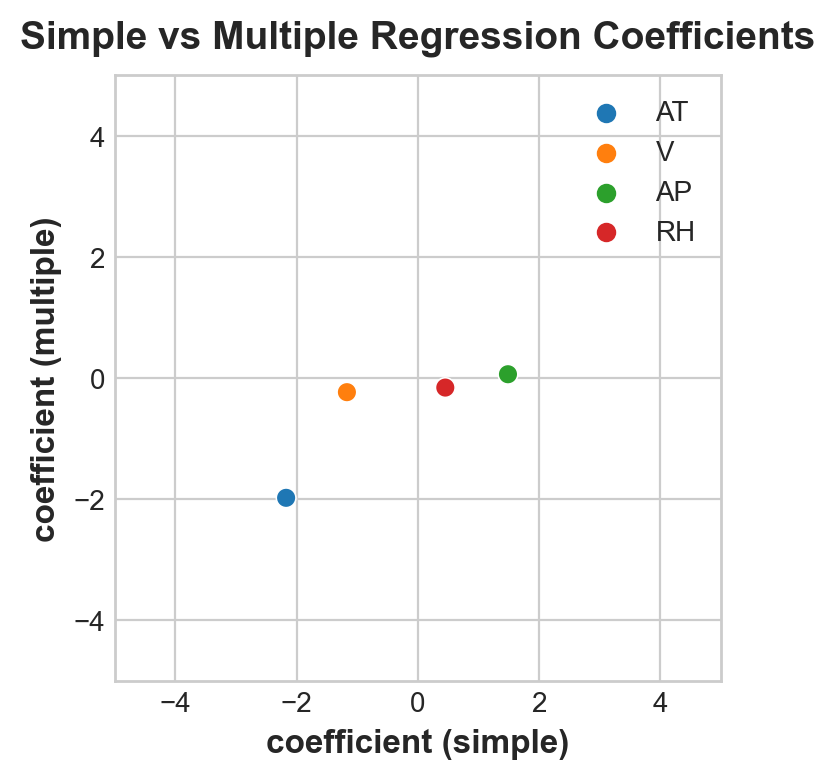

In [189]:
# Create a plot displaying the univariate regression coefficients from 1c on the x-axis, and the multiple regression coefficients from 1d on the y-axis. That is, each predictor is displayed as a single point in the plot. Its coefficient in a simple linear regression model is shown on the x-axis, and its coefficient estimate in the multiple linear regression model is shown on the y-axis.

fig, ax = plt.subplots()
sns.scatterplot(data=combined_summary_df, x='coefficient (simple)', y='coefficient (multiple)', hue=combined_summary_df.index, s=50)
ax.set_title('Simple vs Multiple Regression Coefficients');
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.set_aspect('equal')

### (f) Nonlinear Association

### (g) Interactions of Predictors

### (h) Improvement

### (i) KNN

### (j ) Compare KNN and Linear

## 2. ISLR: 2.4.1

### (a) The sample size n is extremely large, and the number of predictors p is small.

### (b) The number of predictors p is extremely large, and the number of observations n is small.

### (c) The relationship between the predictors and response is highly non-linear.

### (d) The variance of the error terms, i.e. $σ^2$ = Var(ε), is extremely high.

## 3. ISLR: 2.4.7

### (a) Compute the Euclidean distance between each observation and the test point, X1 = X2 = X3 = 0.

### (b) What is our prediction with K = 1? Why?

### (c) What is our prediction with K = 3? Why?

### (d) If the Bayes decision boundary in this problem is highly non-linear, then would we expect the best value for K to be large or small? Why?

## References and Citations

- https://stackoverflow.com/questions/2942889/reading-parsing-excel-xls-files-with-python/50815107#50815107
- https://www.kaggle.com/code/ryanholbrook/linear-regression-with-time-series
- https://melaniewalsh.github.io/Intro-Cultural-Analytics/03-Data-Analysis/01-Pandas-Basics-Part1.html#
- https://stackoverflow.com/questions/54822884/how-to-change-the-x-axis-range-in-seaborn